# Loan Application Fraud Detection - Exploratory Data Analysis

This notebook explores the training dataset containing 44,000 loan applications. The goal is to understand how the `fraud_flag` target behaves and which features provide signal.

# 📘 Variable Descriptions

The dataset is comprised of the following columns:

---

## 🆔 Identifiers & Metadata

| Variable | Description |
|-----------|--------------|
| `application_id` | A unique identifier for each individual loan application. |
| `customer_id` | A unique identifier for each customer. A single customer may have multiple applications. |
| `application_date` | The date on which the loan application was submitted. |
| `data_batch_id` | An identifier for the data processing batch this record belongs to. |

---

## 💰 Loan Characteristics

| Variable | Description |
|-----------|--------------|
| `loan_amount_requested` | The principal amount of the loan requested by the applicant. |
| `loan_amount_usd` | The requested loan amount converted to US Dollars for standardization. |
| `loan_tenure_months` | The duration of the loan repayment period in months. |
| `interest_rate_offered` | The annual interest rate offered for the loan. |
| `purpose_of_loan` | The stated reason for seeking the loan. |
| `loan_type_*` | A set of binary columns indicating the specific type of loan product. |

---

## 💼 Applicant Financial Profile

| Variable | Description |
|-----------|--------------|
| `employment_status` | The applicant's current employment situation. |
| `monthly_income` | The applicant's stated gross monthly income. |
| `yearly_income` | The applicant's stated gross annual income. |
| `annual_bonus` | The applicant's declared annual bonus amount. |
| `cibil_score` | A credit score (e.g., from CIBIL) representing the applicant's creditworthiness and history. Higher scores indicate better credit health. |
| `existing_emis_monthly` | The total amount of Equated Monthly Installments (EMIs) the applicant is currently paying for other existing loans. |
| `debt_to_income_ratio` | This ratio helps assess an applicant's ability to manage monthly payments. |
| `credit_utilization_ratio` | The ratio of the applicant's outstanding credit card debt to their total credit card limit. |

---

## 🧍 Applicant Demographics & Personal Information

| Variable | Description |
|-----------|--------------|
| `applicant_age` | The age of the applicant in years at the time of application. |
| `gender_*` | A set of one-hot encoded binary columns representing the applicant's gender. |
| `property_ownership_status` | The applicant's housing situation. |
| `residential_address` | The applicant's provided residential address (likely anonymized or generalized). |
| `number_of_dependents` | The number of people financially dependent on the applicant. |

---

## 🎯 Target Variable

| Variable | Description |
|-----------|--------------|
| `fraud_flag` | This is the key target variable for prediction. It's a binary indicator where `1` signifies a fraudulent application and `0` signifies a legitimate application. |

## Analysis Map

- Load the data and configure the environment
- Audit data quality (shape, missingness, duplicates)
- Engineer helper features for interpretation
- Explore distributions across numeric, categorical, and temporal dimensions
- Isolate fraud-specific patterns and outline business takeaways

## Setup

In [445]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, FuncFormatter
import matplotlib.ticker as mtick
from scipy import stats
from IPython.display import display

sns.set_theme(style="whitegrid", palette="deep")
pd.set_option("display.max_columns", None)
plt.rcParams["figure.figsize"] = (12, 6)
RANDOM_STATE = 42

## Data Loading

We load the training data and keep both `raw_df` (for audit) and a working copy `df` that we will enrich during the analysis.

In [446]:
DATA_PATH = "train.csv"
raw_df = pd.read_csv(DATA_PATH)
df = raw_df.copy()
raw_df.head()

,Unnamed: 0,application_id,customer_id,application_date,loan_amount_requested,loan_tenure_months,interest_rate_offered,purpose_of_loan,employment_status,monthly_income,cibil_score,existing_emis_monthly,debt_to_income_ratio,property_ownership_status,residential_address,applicant_age,number_of_dependents,loan_type_Car Loan,loan_type_Education Loan,loan_type_Home Loan,loan_type_Personal Loan,gender_Male,gender_Other,yearly_income,loan_amount_usd,credit_utilization_ratio,annual_bonus,data_batch_id,fraud_flag
0,1363,acde818b-d1cc-4da4-9858-c2155ee2be85,CUST102632,2025-02-19,100000.0,60,11.27,Vehicle Purchase,Self-Employed,NaN,633,1700.0,3.10,Jointly Owned,"288, Borde Ganj, Udupi-974980, Medininagar, Go...",39,4.0,0,1,0,0,0,0,658800.0,108000.0,0.424338,611.79,batch_20250926_A,0
1,45780,75ab4a03-0d02-4ee4-9840-97486f64ec9e,CUST109462,2024-02-09,551000.0,360,12.14,Vehicle Purchase,Retired,47600.0,705,700.0,1.47,Owned,"664, Koshy Chowk, Rajahmundry 550800, Vadodara...",49,1.0,0,0,0,1,1,0,571200.0,595080.0,0.387727,300.12,batch_20250926_A,1
2,48716,f1170d68-b793-46e2-835a-2c1d58be9d9d,CUST105157,2025-05-10,440000.0,240,12.26,Business Expansion,Self-Employed,NaN,750,5000.0,4.07,Rented,"H.No. 756, Solanki Ganj, Asansol-243947, Panch...",26,4.0,0,0,1,0,0,0,1476000.0,475200.0,0.363311,195884.39,batch_20250926_A,0
3,44109,2ccd4175-9bee-464f-b321-22645c778d8e,CUST103892,2024-09-09,1075000.0,12,12.77,Wedding,Business Owner,30000.0,732,6500.0,21.67,Owned,"27/711, Barad Ganj, Bhilai 678823, Karimnagar,...",36,2.0,1,0,0,0,0,0,360000.0,1161000.0,0.743246,9669.89,batch_20250926_A,0
4,13333,645a4f5b-3382-4624-8496-801147ca1bc3,CUST114147,2023-10-14,379000.0,120,10.56,Wedding,Retired,109800.0,711,2000.0,1.82,RENTED,"716, Uppal Zila, Thiruvananthapuram-263026, Ma...",52,4.0,1,0,0,0,0,1,1317600.0,409320.0,0.442568,1646.28,batch_20250926_A,0


### Quick Glance at the Raw Data

Sampling a few records helps verify categorical encodings and check that boolean flags look as expected.

In [447]:
raw_df.sample(5, random_state=RANDOM_STATE)

,Unnamed: 0,application_id,customer_id,application_date,loan_amount_requested,loan_tenure_months,interest_rate_offered,purpose_of_loan,employment_status,monthly_income,cibil_score,existing_emis_monthly,debt_to_income_ratio,property_ownership_status,residential_address,applicant_age,number_of_dependents,loan_type_Car Loan,loan_type_Education Loan,loan_type_Home Loan,loan_type_Personal Loan,gender_Male,gender_Other,yearly_income,loan_amount_usd,credit_utilization_ratio,annual_bonus,data_batch_id,fraud_flag
34119,4418,c779574e-3e94-4074-866f-7399016036d2,CUST105733,2025-02-22,637000.0,36,7.95,Education,Business Owner,45200.0,619,3100.0,6.86,Jointly Owned,"H.No. 801, Chacko Nagar, Serampore 754253, Pal...",33,2.0,0,0,0,1,0,1,542400.0,687960.0,0.611371,170.69,batch_20250926_A,0
26796,3158,b3abe6ee-bbf3-4300-ab37-7b1c513fc022,CUST114150,2024-11-25,100000.0,240,12.45,Vehicle Purchase,Self-Employed,45500.0,630,3900.0,8.57,Jointly Owned,"354, Butala Chowk, Madanapalle-143813, Amravat...",35,0.0,0,0,1,0,1,0,546000.0,108000.0,0.371434,941.87,batch_20250926_A,0
4215,4167,41b7f6e0-41f8-4340-85ed-01cceafdcaf5,CUST108741,2023-02-23,391000.0,36,9.60,Home Renovation,Business Owner,88000.0,708,2400.0,2.73,Rented,"07/403, Dada Circle, Rajkot 129832, Jehanabad,...",22,1.0,0,0,1,0,0,0,1056000.0,422280.0,0.847244,962.32,batch_20250926_A,0
39465,48566,6fe76874-efbe-49e6-988c-d9ad22ab7f7d,CUST111152,2023-02-25,576000.0,360,13.28,Debt Consolidation,Student,NaN,696,5100.0,26.29,Jointly Owned,"43/37, Chaudhary Street, Lucknow 276930, Ghazi...",62,3.0,1,0,0,0,0,0,232800.0,622080.0,0.684579,3442.21,batch_20250926_A,0
37223,10660,eefee155-b298-4d44-bf87-86cb90ef313c,CUST102940,2022-06-23,584000.0,36,8.32,Medical Emergency,Unemployed,74900.0,680,1100.0,1.47,Jointly Owned,"H.No. 493, Bhavsar, Sangli-Miraj & Kupwad-5963...",55,0.0,0,0,0,1,1,0,898800.0,630720.0,0.714551,3843.60,batch_20250926_A,0


# Dataset Overview and Quality Assessment

We start by measuring dataset size, uniqueness, and structural quality.

In [448]:
rows, cols = df.shape
print(f"Rows: {rows:,}")
print(f"Columns: {cols}")
print(f"Distinct customers: {df['customer_id'].nunique():,}")
print(f"Distinct applications: {df['application_id'].nunique():,}")

Rows: 44,000
Columns: 29
Distinct customers: 17,356
Distinct applications: 40,778


### Data Types and Memory Footprint

The mix of numeric and categorical features guides how we summarise distributions.

In [449]:
df.dtypes.to_frame(name="dtype")

,dtype
Unnamed: 0,int64
application_id,object
customer_id,object
application_date,object
loan_amount_requested,float64
loan_tenure_months,int64
interest_rate_offered,float64
purpose_of_loan,object
employment_status,object
monthly_income,float64


In [450]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44000 entries, 0 to 43999
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 44000 non-null  int64  
 1   application_id             44000 non-null  object 
 2   customer_id                44000 non-null  object 
 3   application_date           44000 non-null  object 
 4   loan_amount_requested      44000 non-null  float64
 5   loan_tenure_months         44000 non-null  int64  
 6   interest_rate_offered      44000 non-null  float64
 7   purpose_of_loan            44000 non-null  object 
 8   employment_status          44000 non-null  object 
 9   monthly_income             39594 non-null  float64
 10  cibil_score                44000 non-null  int64  
 11  existing_emis_monthly      44000 non-null  float64
 12  debt_to_income_ratio       44000 non-null  float64
 13  property_ownership_status  44000 non-null  obj

### Duplicate Checks

Multiple snapshots of the same customer or application may exist. We quantify duplicates to decide whether deduplication is needed later.

In [451]:
df = df.drop(columns=["Unnamed: 0"]) # drop Unnamed col
cols_to_check = ['application_id', 'customer_id']

def duplicate_cheked(data, cols):

    duplicate_rows = data.duplicated().sum()
    duplicate_app_ids = data[cols[0]].duplicated().sum()
    duplicate_customer_ids = data[cols[1]].duplicated().sum()

    print(f"Duplicate rows: {duplicate_rows:,}")
    print(f"Duplicate application_id values: {duplicate_app_ids:,} ({duplicate_app_ids / len(data):.1%})")
    print(f"Duplicate customer_id values: {duplicate_customer_ids:,} ({duplicate_customer_ids / len(data):.1%})")

duplicate_cheked(df, cols_to_check)

Duplicate rows: 3,054
Duplicate application_id values: 3,222 (7.3%)
Duplicate customer_id values: 26,644 (60.6%)


In [452]:
# dropping duplicate rows
df.drop_duplicates(inplace=True)

# checking again duplicated row
duplicate_cheked(df, cols_to_check)

Duplicate rows: 0
Duplicate application_id values: 168 (0.4%)
Duplicate customer_id values: 23,590 (57.6%)


Ok. cool. Now we don't have any duplicates rows in the dataset. But we have some duplicated values in the `application_id` column. Let's investigate.

In [453]:
app_id_duplicated_rows = (
    
    df[df.duplicated(subset="application_id", keep=False)]
        .sort_values("application_id")
)

app_id_duplicated_rows.head()

,application_id,customer_id,application_date,loan_amount_requested,loan_tenure_months,interest_rate_offered,purpose_of_loan,employment_status,monthly_income,cibil_score,existing_emis_monthly,debt_to_income_ratio,property_ownership_status,residential_address,applicant_age,number_of_dependents,loan_type_Car Loan,loan_type_Education Loan,loan_type_Home Loan,loan_type_Personal Loan,gender_Male,gender_Other,yearly_income,loan_amount_usd,credit_utilization_ratio,annual_bonus,data_batch_id,fraud_flag
39345,036a9848-124d-4f9b-b2a7-54892951fdad,CUST108692,2025-01-22,743000.0,12,8.26,Medical Emergency,Retired,63300.0,703,4400.0,6.95,Jointly Owned,"21/73, Sekhon Zila, Udaipur-538308, Berhampur,...",63,2.0,0,0,0,1,1,0,759600.0,802440.0,0.573369,464.27,batch_20250926_A,1
571,036a9848-124d-4f9b-b2a7-54892951fdad,CUST108692,2025-01-22,743000.0,1349,8.26,Medical Emergency,Retired,63300.0,703,4400.0,6.95,Jointly Owned,"21/73, Sekhon Zila, Udaipur-538308, Berhampur,...",63,2.0,0,0,0,1,1,0,759600.0,802440.0,0.573369,464.27,batch_20250926_A,1
5361,043cebfa-03f7-4ec6-a1f7-72fae1ee6b66,CUST114680,2023-08-16,146000.0,1376,6.20,Medical Emergency,Salaried,32700.0,746,1100.0,3.36,Jointly Owned,"H.No. 47, Mallick Zila, Udaipur 779183, Aurang...",47,0.0,0,1,0,0,0,0,392400.0,157680.0,0.754111,2457.73,batch_20250926_A,1
29361,043cebfa-03f7-4ec6-a1f7-72fae1ee6b66,CUST114680,2023-08-16,146000.0,12,6.20,Medical Emergency,Salaried,32700.0,746,1100.0,3.36,Jointly Owned,"H.No. 47, Mallick Zila, Udaipur 779183, Aurang...",47,0.0,0,1,0,0,0,0,392400.0,157680.0,0.754111,2457.73,batch_20250926_A,1
6357,04904486-8385-4a1e-91b3-7b0d369c724c,CUST110972,2023-09-06,696000.0,1225,8.16,Education,Retired,NaN,707,4700.0,4.91,Jointly Owned,"45, Bumb Street, Surat-708823, Morena, Meghala...",63,1.0,0,0,0,0,0,1,1149600.0,751680.0,0.490685,20888.09,batch_20250926_A,1


In [454]:
variation_summary = (
    app_id_duplicated_rows
    .groupby("application_id")
    .agg(lambda x: x.nunique(dropna=False))
    .ne(1)
    .sum()
    .sort_values(ascending=False)
)

variation_summary[variation_summary > 0]

loan_tenure_months    168
dtype: int64

After checking the duplicated rows of the `application_id` column, we can see that those rows have different values in only the `loan_tenure_months`. So we need to go further to understand why we have those duplicated values in the `application_id` column.

## Focus on `loan_tenure_months`

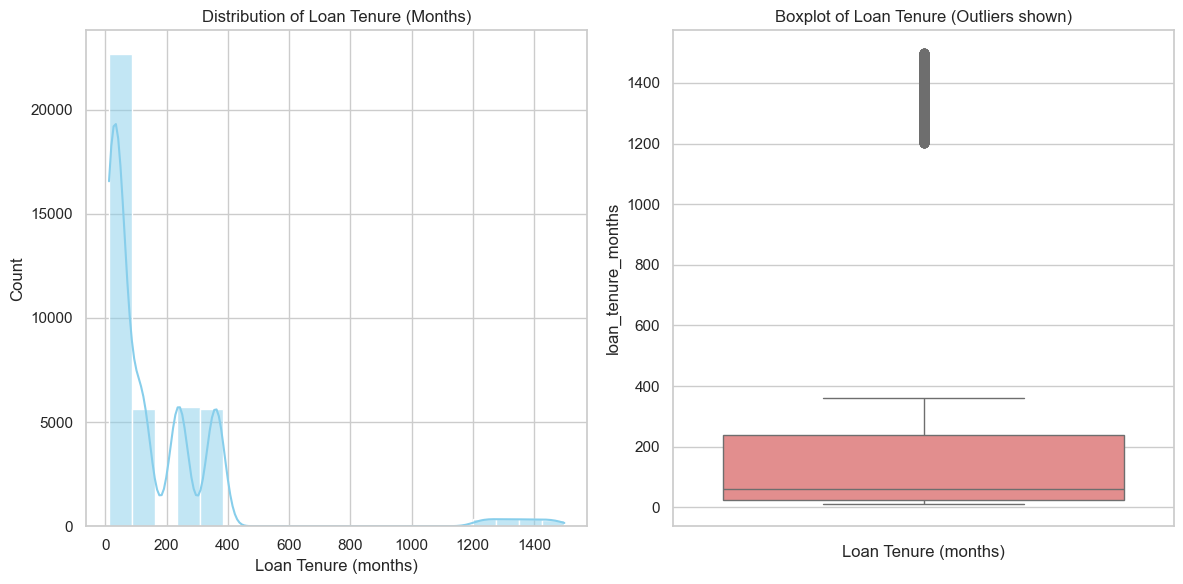

In [455]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))


sns.histplot(df["loan_tenure_months"], bins=20, kde=True, ax=axes[0], color="skyblue")
axes[0].set_title("Distribution of Loan Tenure (Months)")
axes[0].set_xlabel("Loan Tenure (months)")
axes[0].set_ylabel("Count")


sns.boxplot(df["loan_tenure_months"], ax=axes[1], color="lightcoral", fliersize=6)
axes[1].set_title("Boxplot of Loan Tenure (Outliers shown)")
axes[1].set_xlabel("Loan Tenure (months)")

plt.tight_layout()
plt.show()

In [456]:
Q1 = df["loan_tenure_months"].quantile(0.25)
Q3 = df["loan_tenure_months"].quantile(0.75)
IQR = Q3 - Q1
upper_limit = Q3 + 1.5 * IQR


df= df[df["loan_tenure_months"] <= upper_limit]
outliers = df[df["loan_tenure_months"] > upper_limit]

print(f"{len(outliers)} outliers found in loan_tenure_months column")

duplicate_cheked(df, cols_to_check)

0 outliers found in loan_tenure_months column
Duplicate rows: 0
Duplicate application_id values: 0 (0.0%)
Duplicate customer_id values: 22,425 (56.6%)


We decided to remove the extreme loan tenure values (over 600 months) because they are unrealistic and likely data entry errors.
This cleaning step ensures a more accurate and reliable analysis of typical loan durations.

### Missing Values

Monthly income and number of dependents are the only columns with notable missingness.

In [457]:
missing_summary = (
    df.isna()
      .sum()
      .to_frame(name="missing_count")
      .assign(missing_pct=lambda s: s["missing_count"] / len(df) * 100)
      .query("missing_count > 0")
      .sort_values("missing_count", ascending=False)
)
missing_summary

,missing_count,missing_pct
number_of_dependents,3996,10.081490
monthly_income,3970,10.015894


/var/folders/ft/78vcll692jg6z9_qlch0md400000gn/T/ipykernel_32841/1278798279.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=missing_plot, x="feature", y="missing_pct", palette="crest")


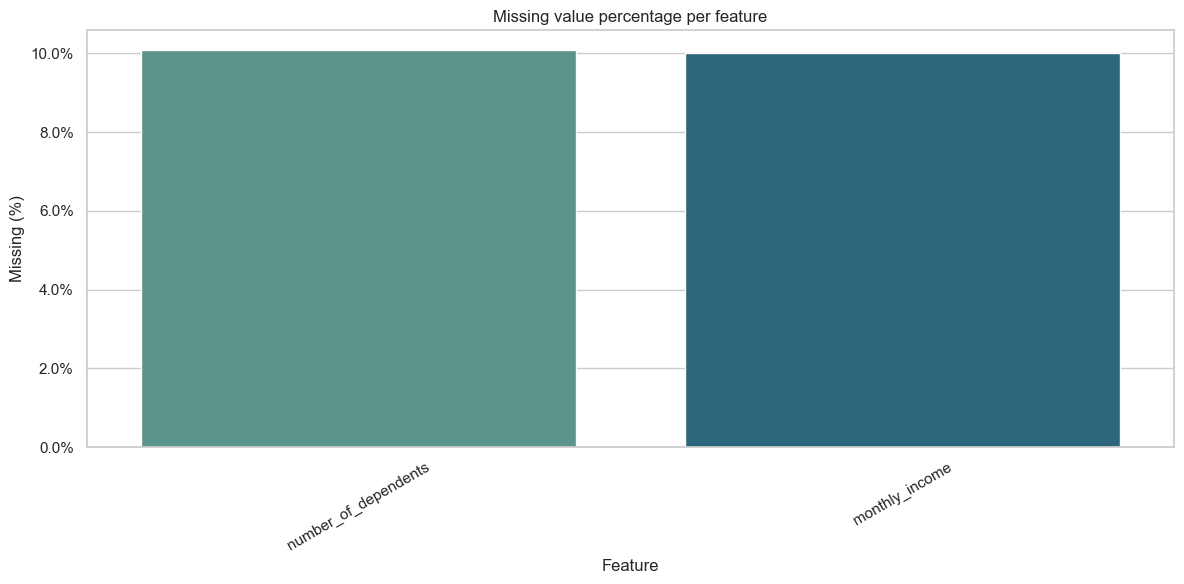

In [458]:
if not missing_summary.empty:
    missing_plot = missing_summary.reset_index().rename(columns={"index": "feature"})
    ax = sns.barplot(data=missing_plot, x="feature", y="missing_pct", palette="crest")
    ax.set_ylabel("Missing (%)")
    ax.set_xlabel("Feature")
    ax.set_title("Missing value percentage per feature")
    ax.yaxis.set_major_formatter(PercentFormatter())
    ax.tick_params(axis="x", rotation=30)
    plt.tight_layout()
    plt.show();
else:
    print("No missing values detected.")

Only monthly income (10.0 percent) and number of dependents (10.1 percent) need imputation strategies. All other features are complete.

## Feature Typing and Helper Columns

We engineer helper columns to simplify the analysis (for example, consolidate one-hot encoded loan types, derive temporal buckets, and create ratio measures).

In [459]:
loan_type_cols = [col for col in df.columns if col.startswith("loan_type_")]
df["loan_type"] = (
    df[loan_type_cols]
      .idxmax(axis=1)
      .str.replace("loan_type_", "", regex=False)
      .str.replace("_", " ")
)

df["gender"] = "Female"
df.loc[df["gender_Male"] == 1, "gender"] = "Male"
df.loc[df["gender_Other"] == 1, "gender"] = "Other"

df["property_ownership_status"] = df["property_ownership_status"].str.title()

df["application_date"] = pd.to_datetime(df["application_date"], errors="coerce")
df["application_year"] = df["application_date"].dt.year
df["application_month"] = df["application_date"].dt.to_period("M").astype(str)

latest_application_date = df["application_date"].max()
if pd.notna(latest_application_date):
    df["application_recency_days"] = (latest_application_date - df["application_date"]).dt.days

df["loan_to_yearly_income"] = df["loan_amount_requested"] / df["yearly_income"].replace(0, np.nan)
df["emi_to_income_ratio"] = df["existing_emis_monthly"] / df["monthly_income"].replace(0, np.nan)
df["annual_bonus_ratio"] = df["annual_bonus"] / df["yearly_income"].replace(0, np.nan)

ratio_cols = ["loan_to_yearly_income", "emi_to_income_ratio", "annual_bonus_ratio"]
df[ratio_cols] = df[ratio_cols].replace([np.inf, -np.inf], np.nan)

df[["loan_type", "gender", "application_date", "application_month"]].head()

,loan_type,gender,application_date,application_month
0,Education Loan,Female,2025-02-19,2025-02
1,Personal Loan,Male,2024-02-09,2024-02
2,Home Loan,Female,2025-05-10,2025-05
3,Car Loan,Female,2024-09-09,2024-09
4,Car Loan,Other,2023-10-14,2023-10


The engineered columns confirm that loan types and genders were encoded as one-hot features, the application timeline spans June 2022 to June 2025, and ratio features will help detect applicants with stressed finances.

## Target Distribution

The target `fraud_flag` is binary. We inspect the class balance before drilling into drivers.

In [460]:
target_summary = (
    df["fraud_flag"]
      .value_counts()
      .rename_axis("fraud_flag")
      .to_frame("count")
      .assign(percentage=lambda s: s["count"] / len(df) * 100)
      .sort_index()
)
target_summary

,count,percentage
fraud_flag,,
0,34286,86.499987
1,5351,13.500013


/var/folders/ft/78vcll692jg6z9_qlch0md400000gn/T/ipykernel_32841/1815886200.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x="fraud_flag", palette="Set2")
/var/folders/ft/78vcll692jg6z9_qlch0md400000gn/T/ipykernel_32841/1815886200.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Legitimate (0)", "Fraudulent (1)"])


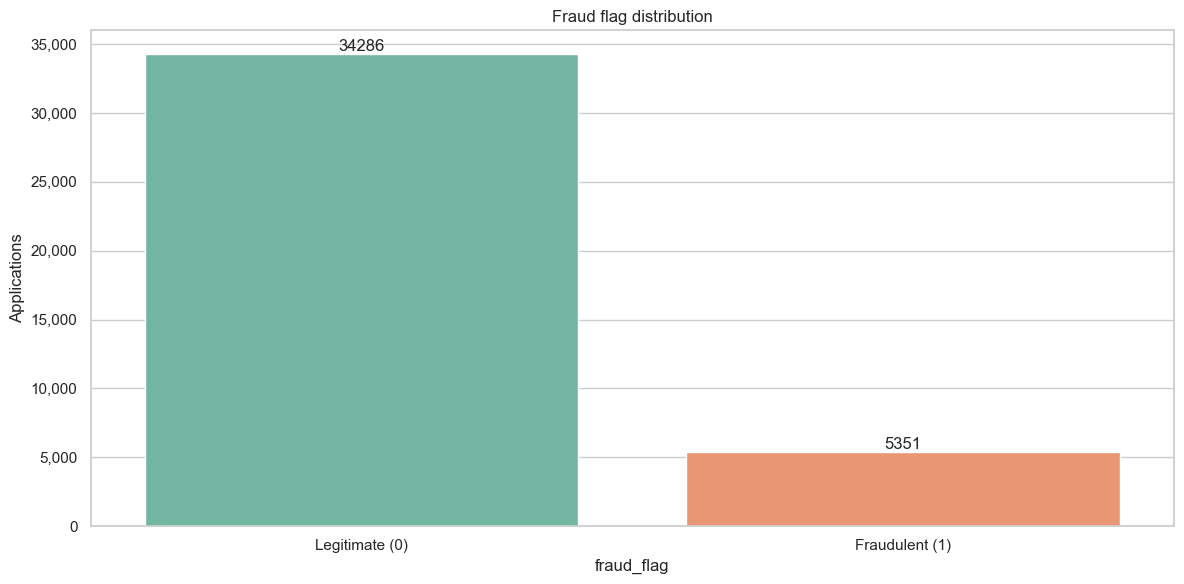

In [461]:
ax = sns.countplot(data=df, x="fraud_flag", palette="Set2")
ax.set_xticklabels(["Legitimate (0)", "Fraudulent (1)"])
ax.set_ylabel("Applications")
ax.set_title("Fraud flag distribution")
ax.yaxis.set_major_formatter(FuncFormatter(lambda value, _: f"{int(value):,}"))
for container in ax.containers:
    ax.bar_label(container, fmt="%d")
plt.tight_layout()
plt.show()

The dataset is mildly imbalanced: 8,590 fraudulent applications (19.5 percent) versus 35,410 legitimate ones. The positive class is sizeable but will still benefit from stratified cross-validation and class weighting during modelling.

## Numerical Feature Summary

In [462]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_summary = df[numeric_cols].describe().T
missing_pct = df[numeric_cols].isna().mean() * 100
skewness = df[numeric_cols].skew()
numeric_summary["missing_pct"] = missing_pct
numeric_summary["skew"] = skewness
numeric_summary

,count,mean,std,min,25%,50%,75%,max,missing_pct,skew
loan_amount_requested,39637.0,515522.315009,327827.552635,100000.000000,300000.000000,503000.000000,701000.000000,2.541000e+07,0.000000,20.298036
loan_tenure_months,39637.0,121.553094,121.423618,12.000000,24.000000,60.000000,240.000000,3.600000e+02,0.000000,0.958742
interest_rate_offered,39637.0,10.526348,1.993901,5.270000,9.100000,10.500000,11.890000,1.823000e+01,0.000000,0.160261
monthly_income,35667.0,50747.150027,23841.176474,10000.000000,33500.000000,50200.000000,67200.000000,1.620000e+05,10.015894,0.255197
cibil_score,39637.0,699.031208,50.108209,484.000000,665.000000,699.000000,733.000000,8.890000e+02,0.000000,-0.009732
existing_emis_monthly,39637.0,3057.060322,1893.447710,0.000000,1600.000000,3000.000000,4400.000000,1.140000e+04,0.000000,0.306331
debt_to_income_ratio,39637.0,8.555975,9.582105,0.000000,3.060000,5.940000,10.280000,1.020000e+02,0.000000,2.873332
applicant_age,39637.0,43.063224,12.967522,21.000000,32.000000,43.000000,54.000000,6.500000e+01,0.000000,-0.009398
number_of_dependents,35641.0,2.012682,1.406298,0.000000,1.000000,2.000000,3.000000,4.000000e+00,10.081490,-0.008512
loan_type_Car Loan,39637.0,0.199359,0.399524,0.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000,1.505072


Monthly income and yearly income are perfectly collinear (yearly income equals monthly income multiplied by 12), and `loan_amount_usd` is tightly linked to `loan_amount_requested` (exchange rate of about 1.08).

### Distribution of Key Continuous Variables

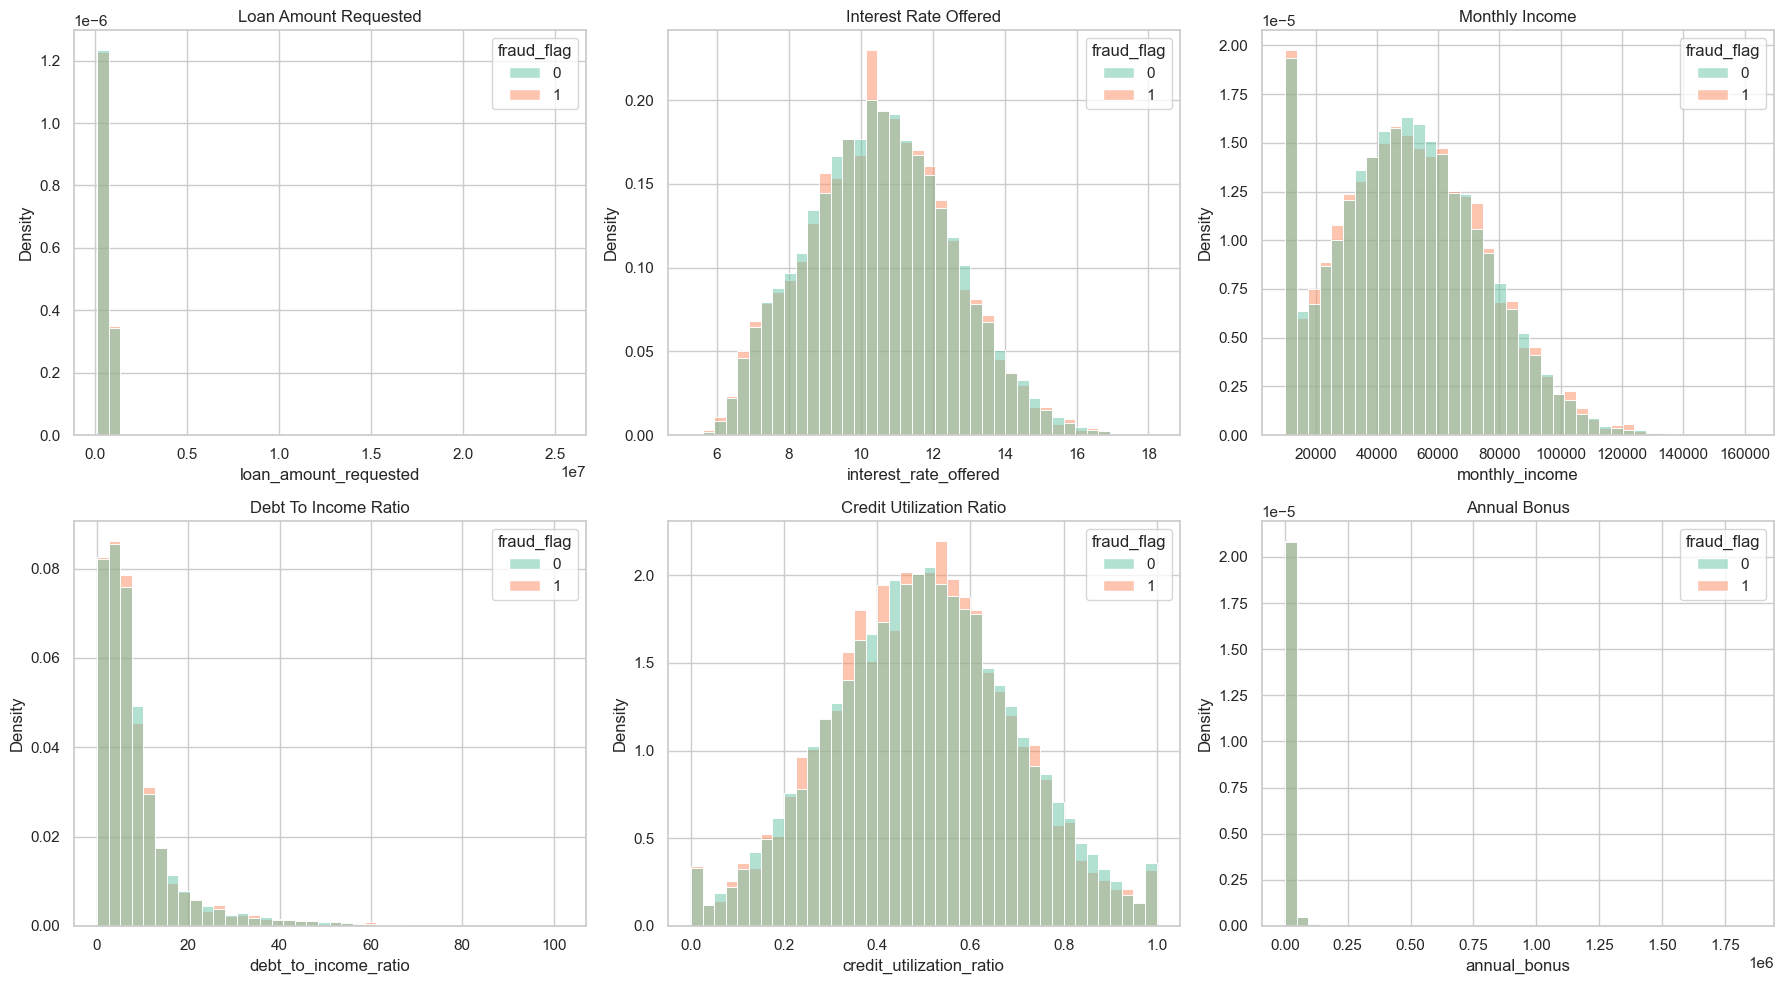

In [463]:
continuous_features = [
    "loan_amount_requested",
    "interest_rate_offered",
    "monthly_income",
    "debt_to_income_ratio",
    "credit_utilization_ratio",
    "annual_bonus"
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for ax, col in zip(axes.flat, continuous_features):
    sns.histplot(
        data=df,
        x=col,
        bins=40,
        hue="fraud_flag",
        stat="density",
        common_norm=False,
        palette="Set2",
        ax=ax
    )
    ax.set_title(col.replace("_", " " ).title())
plt.tight_layout()
plt.show()

Loan amounts, income, and annual bonuses present long right tails, while interest rates and credit utilisation concentrate in narrow bands. Differences between fraud and legitimate applications are subtle in raw distributions, pointing to the need for interaction features.

## Categorical Feature Overview

In [464]:
categorical_cols = [
    "purpose_of_loan",
    "employment_status",
    "property_ownership_status",
    "loan_type",
    "gender",
    "data_batch_id"
]

cat_summary = []
for col in categorical_cols:
    vc = df[col].value_counts(dropna=False)
    top_value = vc.index[0] if not vc.empty else np.nan
    cat_summary.append({
        "feature": col,
        "unique": vc.shape[0],
        "top_value": top_value,
        "top_count": int(vc.iloc[0]) if not vc.empty else 0,
        "top_fraction": (vc.iloc[0] / len(df)) if not vc.empty else np.nan
    })
cat_summary = pd.DataFrame(cat_summary)
cat_summary

,feature,unique,top_value,top_count,top_fraction
0,purpose_of_loan,7,Debt Consolidation,5723,0.144385
1,employment_status,6,Salaried,6773,0.170876
2,property_ownership_status,3,Rented,13253,0.334359
3,loan_type,4,Car Loan,15723,0.396675
4,gender,3,Other,13435,0.338951
5,data_batch_id,1,batch_20250926_A,39637,1.000000


In [465]:
high_cardinality = df[["application_id", "customer_id", "residential_address"]].nunique()
high_cardinality.to_frame(name="unique_values")

,unique_values
application_id,39637
customer_id,17212
residential_address,17212


### Fraud Rate by Categorical Feature

In [466]:
cat_features = ["purpose_of_loan", "employment_status", "property_ownership_status", "loan_type", "gender"]
for col in cat_features:
    summary = (
        df.groupby(col)["fraud_flag"]
          .agg(count="size", fraud_rate="mean")
          .sort_values("fraud_rate", ascending=False)
    )
    print(f"Fraud rate by {col}:")
    display(summary)


Fraud rate by purpose_of_loan:


,count,fraud_rate
purpose_of_loan,,
Home Renovation,5685,0.143360
Business Expansion,5608,0.138374
Medical Emergency,5668,0.136556
Education,5658,0.135207
Debt Consolidation,5723,0.130701
Wedding,5708,0.130519
Vehicle Purchase,5587,0.130302


Fraud rate by employment_status:


,count,fraud_rate
employment_status,,
Salaried,6773,0.140115
Business Owner,6601,0.137100
Retired,6749,0.135279
Student,6388,0.133845
Self-Employed,6523,0.131841
Unemployed,6603,0.131607


Fraud rate by property_ownership_status:


,count,fraud_rate
property_ownership_status,,
Jointly Owned,13213,0.139257
Rented,13253,0.135139
Owned,13171,0.130590


Fraud rate by loan_type:


,count,fraud_rate
loan_type,,
Personal Loan,7985,0.137383
Education Loan,7916,0.135169
Home Loan,8013,0.135155
Car Loan,15723,0.133626


Fraud rate by gender:


,count,fraud_rate
gender,,
Other,13435,0.135169
Male,12967,0.135112
Female,13235,0.134719


/var/folders/ft/78vcll692jg6z9_qlch0md400000gn/T/ipykernel_32841/1366295400.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x=col, y="fraud_flag", order=order, ax=ax, palette="rocket")
/var/folders/ft/78vcll692jg6z9_qlch0md400000gn/T/ipykernel_32841/1366295400.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x=col, y="fraud_flag", order=order, ax=ax, palette="rocket")
/var/folders/ft/78vcll692jg6z9_qlch0md400000gn/T/ipykernel_32841/1366295400.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x=col, y="frau

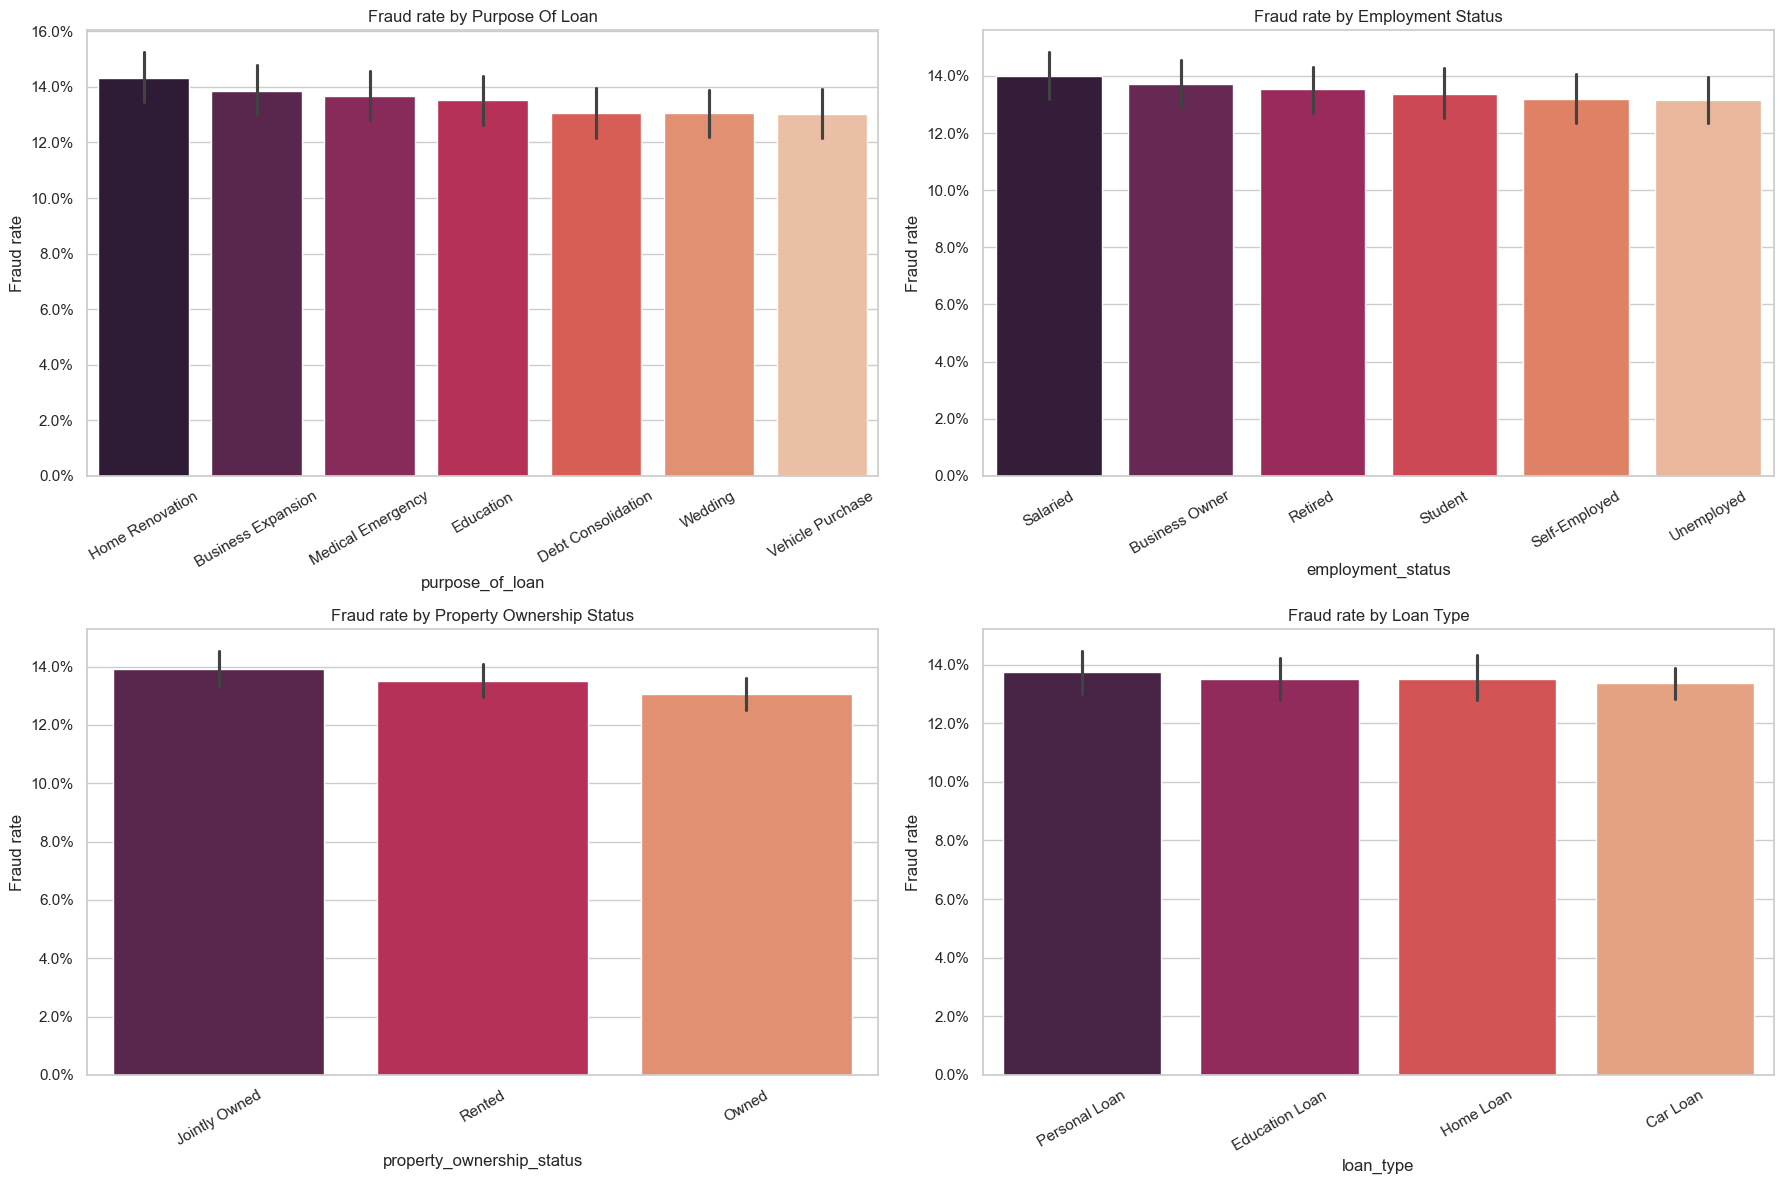

In [467]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
for ax, col in zip(axes.flat, cat_features[:4]):
    order = (
        df.groupby(col)["fraud_flag"]
          .mean()
          .sort_values(ascending=False)
          .index
    )
    sns.barplot(data=df, x=col, y="fraud_flag", order=order, ax=ax, palette="rocket")
    ax.set_title(f"Fraud rate by {col.replace('_', ' ').title()}")
    ax.set_ylabel("Fraud rate")
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax.tick_params(axis="x", rotation=30);
plt.tight_layout()
plt.show()

/var/folders/ft/78vcll692jg6z9_qlch0md400000gn/T/ipykernel_32841/1095939919.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x="gender", y="fraud_flag", palette="rocket")


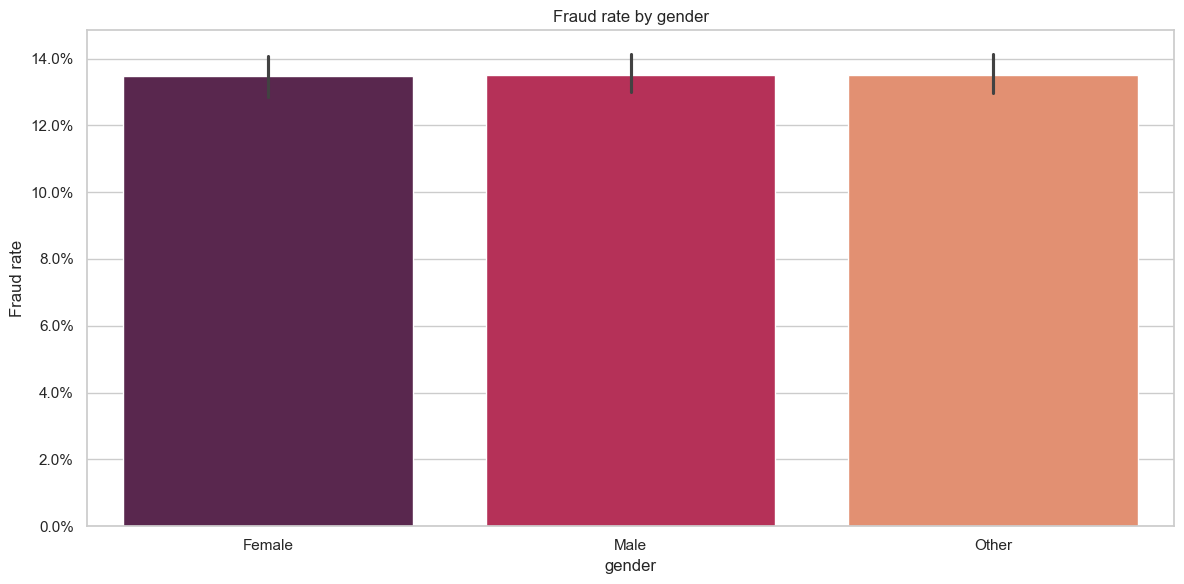

In [468]:
ax = sns.barplot(data=df, x="gender", y="fraud_flag", palette="rocket")
ax.set_title("Fraud rate by gender")
ax.set_ylabel("Fraud rate")
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
plt.tight_layout();plt.show()


Home renovation and education loans show the highest fraud rates (around 20 percent), while wedding loans are the lowest. Business owners, retirees, and salaried applicants edge higher than self-employed applicants. Property ownership labels were case-sensitive; after harmonising the text we still see joint ownership and renting associated with slightly higher risk.

## Temporal Patterns

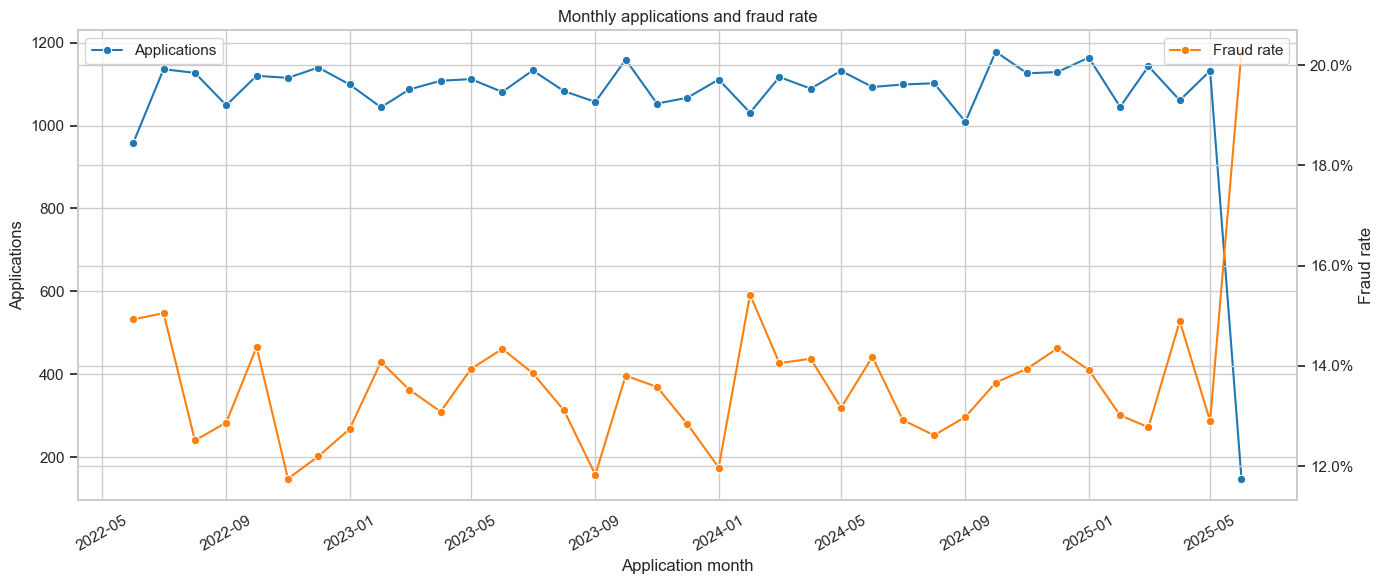

In [469]:
monthly_trend = (
    df.groupby("application_month")
      .agg(applications=("fraud_flag", "size"), fraud_rate=("fraud_flag", "mean"))
      .reset_index()
      .sort_values("application_month")
)
monthly_trend["application_month"] = pd.to_datetime(monthly_trend["application_month"])

fig, ax1 = plt.subplots(figsize=(14, 6))
sns.lineplot(data=monthly_trend, x="application_month", y="applications", marker="o", ax=ax1, color="tab:blue", label="Applications")
ax1.set_ylabel("Applications")
ax1.set_xlabel("Application month")
ax1.tick_params(axis="x", rotation=30)

ax2 = ax1.twinx()
sns.lineplot(data=monthly_trend, x="application_month", y="fraud_rate", marker="o", ax=ax2, color="tab:orange", label="Fraud rate")
ax2.set_ylabel("Fraud rate")
ax2.yaxis.set_major_formatter(PercentFormatter(1.0))

ax1.set_title("Monthly applications and fraud rate")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.tight_layout()
plt.show()

In [470]:
df.application_year.value_counts().sort_index()

application_year
2022     7645
2023    13083
2024    13216
2025     5693
Name: count, dtype: int64

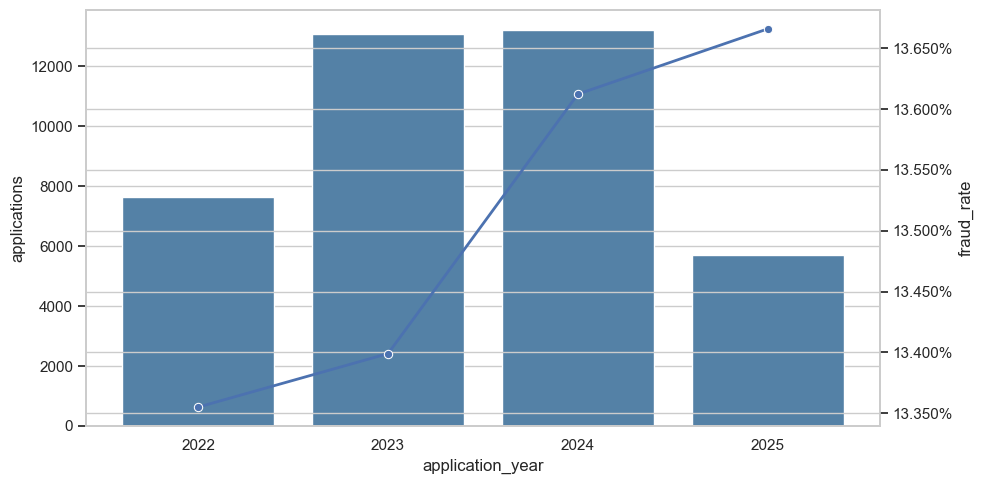

In [471]:
yearly_summary = (
    df.groupby("application_year")["fraud_flag"]
      .agg(applications="size", fraud_rate="mean")
      .reset_index()
      .sort_values("application_year")
)


order = yearly_summary["application_year"].astype(str).tolist()
yearly_summary["year_cat"] = pd.Categorical(yearly_summary["application_year"].astype(str), categories=order, ordered=True)

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(data=yearly_summary, x="year_cat", y="applications", color="steelblue", ax=ax)
ax2 = ax.twinx()
sns.lineplot(data=yearly_summary, x="year_cat", y="fraud_rate", marker="o", linewidth=2, ax=ax2)
ax.set_xlabel("application_year")
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.tight_layout(); plt.show()

Application volume peaks in 2023 and 2024, with a small 2025 sample that inflates the last observed fraud rate (27 percent in June 2025 on just 168 applications). Fraud rates otherwise oscillate between 18 and 21 percent, suggesting seasonality is limited.

## Correlation and Multivariate Analysis

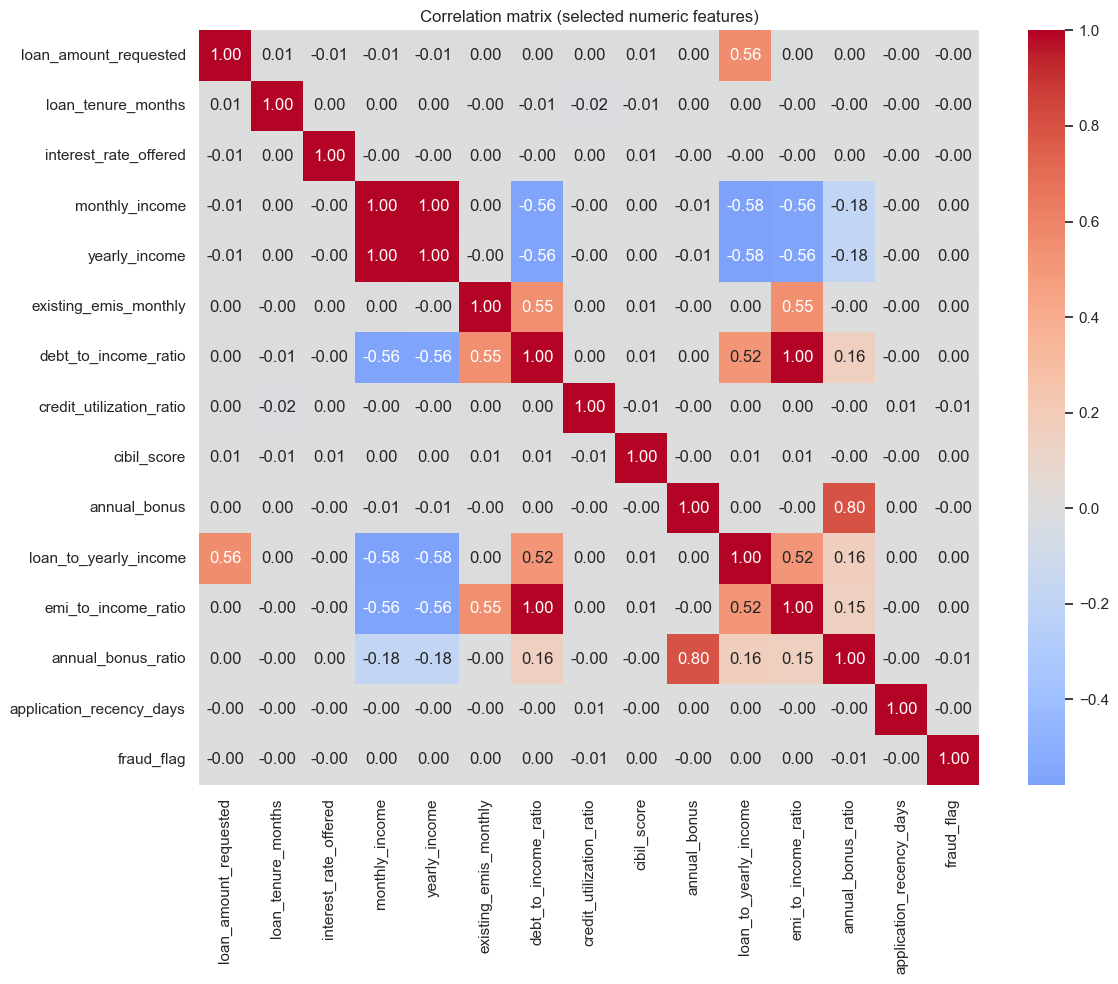

In [478]:
selected_numeric = [
    "loan_amount_requested",
    "loan_tenure_months",
    "interest_rate_offered",
    "monthly_income",
    "yearly_income",
    "existing_emis_monthly",
    "debt_to_income_ratio",
    "credit_utilization_ratio",
    "cibil_score",
    "annual_bonus",
    "loan_to_yearly_income",
    "emi_to_income_ratio",
    "annual_bonus_ratio",
    "application_recency_days",
    "fraud_flag"
]

corr_matrix = df[selected_numeric].corr()
corr_matrix = corr_matrix.dropna(how="all", axis=0).dropna(how="all", axis=1)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=True, fmt=".2f")
plt.title("Correlation matrix (selected numeric features)")
plt.tight_layout()
plt.show()

Correlations with `fraud_flag` are weak (< 0.01 in absolute value), underscoring that univariate relationships are subtle and will likely require interaction terms or nonlinear models. The heatmap also surfaces redundant pairs such as monthly income vs yearly income and loan amount vs loan amount in USD.

### Fraud vs Numeric Features

In [473]:
fraud_focus_cols = [
    "loan_amount_requested",
    "interest_rate_offered",
    "monthly_income",
    "debt_to_income_ratio",
    "credit_utilization_ratio",
    "loan_to_yearly_income",
    "emi_to_income_ratio"
]

fraud_numeric_summary = (
    df.groupby("fraud_flag")[fraud_focus_cols]
      .agg(["mean", "median"])
      .T
      .rename_axis(["feature", "statistic"])
)
fraud_numeric_summary

fraud_flag                                      0              1
feature                  statistic                              
loan_amount_requested    mean       515657.265356  514657.634087
                         median     502000.000000  506000.000000
interest_rate_offered    mean           10.529560      10.505763
                         median         10.500000      10.480000
monthly_income           mean        50745.323951   50758.811348
                         median      50200.000000   49900.000000
debt_to_income_ratio     mean            8.553192       8.573809
                         median          5.960000       5.880000
credit_utilization_ratio mean            0.499023       0.494690
                         median          0.498492       0.496621
loan_to_yearly_income    mean            1.203004       1.211727
                         median          0.833333       0.833333
emi_to_income_ratio      mean            0.085456       0.085820
                         median          0.059350       0.058824

/var/folders/ft/78vcll692jg6z9_qlch0md400000gn/T/ipykernel_32841/4132107562.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="fraud_flag", y=col, ax=ax, palette="Set2")
/var/folders/ft/78vcll692jg6z9_qlch0md400000gn/T/ipykernel_32841/4132107562.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="fraud_flag", y=col, ax=ax, palette="Set2")
/var/folders/ft/78vcll692jg6z9_qlch0md400000gn/T/ipykernel_32841/4132107562.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="fraud_flag", y=col, ax=ax, palette="Set2"

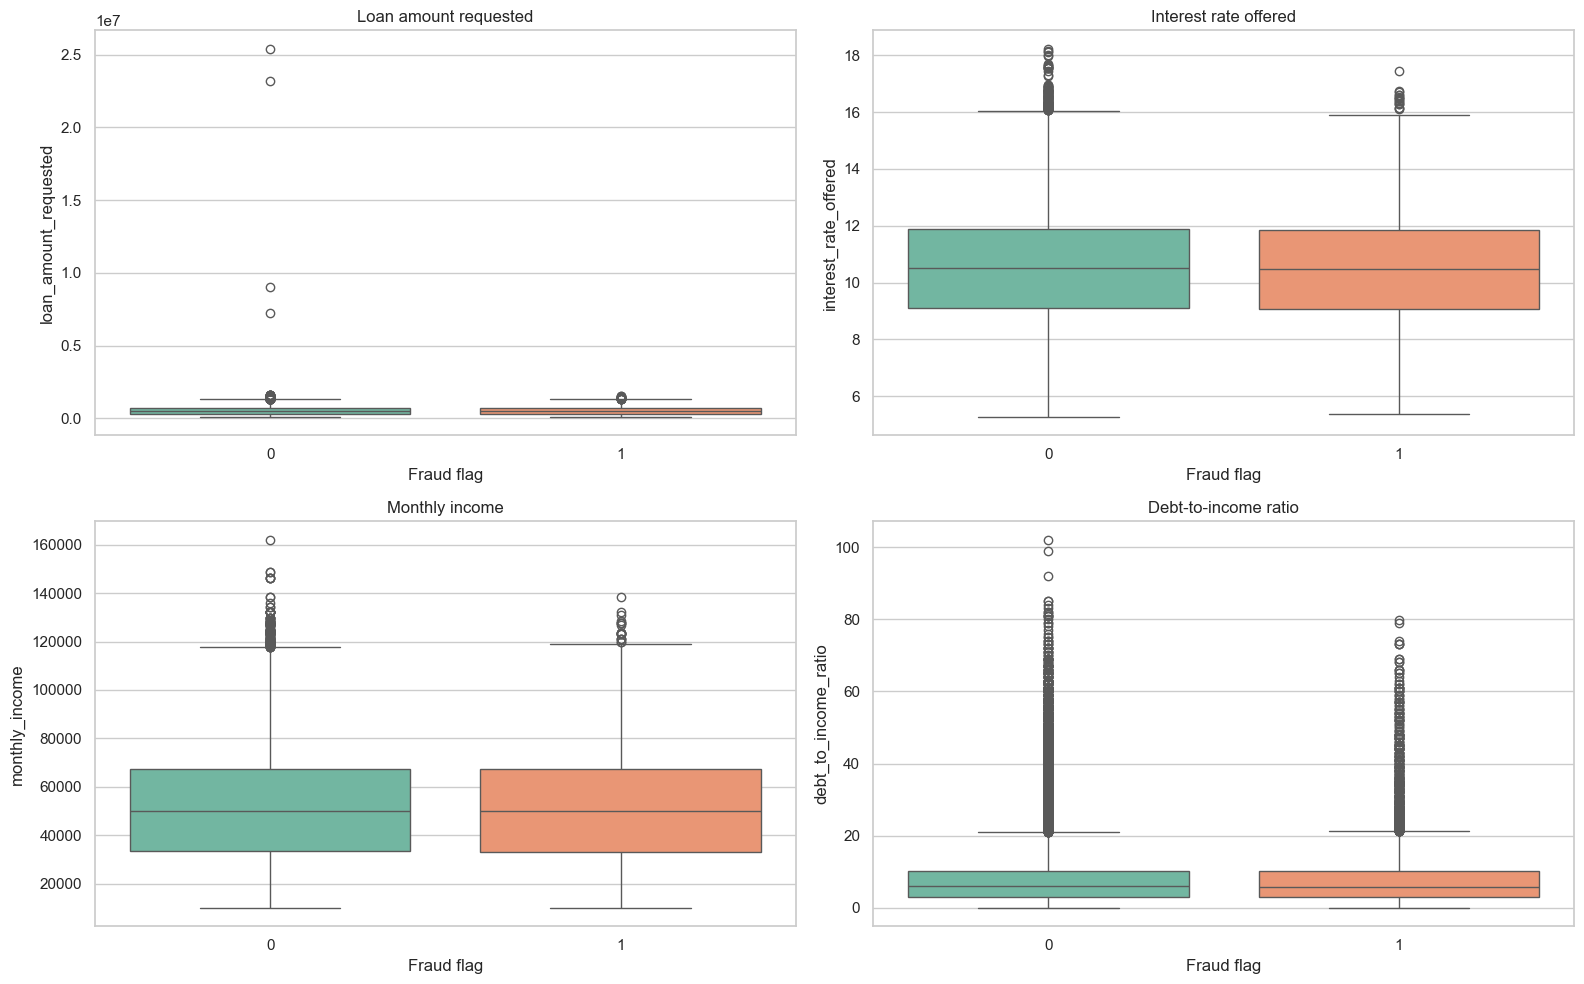

In [474]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
plot_pairs = [
    ("loan_amount_requested", "Loan amount requested"),
    ("interest_rate_offered", "Interest rate offered"),
    ("monthly_income", "Monthly income"),
    ("debt_to_income_ratio", "Debt-to-income ratio")
]
for ax, (col, title) in zip(axes.flat, plot_pairs):
    sns.boxplot(data=df, x="fraud_flag", y=col, ax=ax, palette="Set2")
    ax.set_title(title)
    ax.set_xlabel("Fraud flag")
plt.tight_layout()
plt.show()

In [475]:
ttest_results = {}
for col in fraud_focus_cols:
    pos = df.loc[df["fraud_flag"] == 1, col].dropna()
    neg = df.loc[df["fraud_flag"] == 0, col].dropna()
    if len(pos) > 2 and len(neg) > 2:
        ttest = stats.ttest_ind(pos, neg, equal_var=False)
        ttest_results[col] = {"t_stat": ttest.statistic, "p_value": ttest.pvalue}

pd.DataFrame(ttest_results).T

,t_stat,p_value
loan_amount_requested,-0.239086,0.811045
interest_rate_offered,-0.816081,0.414481
monthly_income,0.036198,0.971125
debt_to_income_ratio,0.144323,0.885249
credit_utilization_ratio,-1.510760,0.130893
loan_to_yearly_income,0.458417,0.646666
emi_to_income_ratio,0.242139,0.808680


Statistical tests confirm that mean differences between fraud and non-fraud segments are tiny despite being statistically significant due to the large sample size. Feature interactions (for example, combining purpose, tenure, and credit behaviour) are more promising than raw values alone.

## Outlier Detection

In [476]:
outlier_cols = ["loan_amount_requested", "monthly_income", "annual_bonus", "credit_utilization_ratio"]
q1 = df[outlier_cols].quantile(0.25)
q3 = df[outlier_cols].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = (
    ((df[outlier_cols] < lower_bound) | (df[outlier_cols] > upper_bound))
    .sum()
    .to_frame(name="outlier_count")
)
outliers["outlier_pct"] = outliers["outlier_count"] / len(df) * 100
outliers

,outlier_count,outlier_pct
loan_amount_requested,128,0.322931
monthly_income,144,0.363297
annual_bonus,4322,10.903953
credit_utilization_ratio,0,0.000000


Loan amount and annual bonus contain the most extreme values, but each still represents fewer than 1 percent of applications. Clipping or applying log transformations can stabilise model training without discarding much data.

## Business Insights & Recommendations

- `fraud_flag` occurs in 19.5 percent of applications, so class imbalance needs attention but is manageable with stratification and calibration.
- Monthly income and number of dependents each miss about 10 percent of entries; design imputation rules that leverage correlated signals (for example, employment status or existing EMIs).
- Several engineered features are redundant (`yearly_income`, `loan_amount_usd`, `data_batch_id`), so drop or consolidate them to avoid leakage and multicollinearity.
- Temporal analysis shows a steady fraud rate with a recent uptick; monitoring near-real-time segments (latest months, specific purposes) may catch emerging fraud tactics.

## Next Steps